Note: Using the optimal sigma value from the coarser mesh for each eigenvalue

Monolayer unit domain. Piecewise PML. Convergence (eigenvalue error)

In [68]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType, KSP
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


In [69]:
# dolfinx.__version__

Domain, PML, refinement and physical configurations

In [70]:
# Define element size for the mesh refinement
h_i = [ 0.0625,
    0.0625 / 2,  #N=2
        0.0625 / 4,  #N=3
        0.0625 / 8,] #N=4


# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)
 
# PML configuration
pml_thickness = Lx/8

# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [71]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    # solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 1000)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-12j)  
    solver.solve()
    n_eigs_converged_piecewise = solver.getConverged()
    
    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [72]:
def get_exact_eigenvalue(n):
    # Exact eigenvalues for the problem
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    return exact_physical_eigs_function(n)

piecewise

In [73]:
# exact = {
#     0: get_exact_eigenvalue(1),
#     3: get_exact_eigenvalue(4)
# }
# sigma_opt={0: 5.5, 3: 3.7}
# target={0: -12j, 3: -50j}

# # Initialize lists to store the approximated eigenpairs
# approx_piecewise_P3_P2 = [[0 for _ in range(5)] for _ in range(len(h_i))]
# for j in [0,3]:
#     for i,h in enumerate(h_i):
#         # Define piecewise sigma function
#         sigma_x_piecewise=lambda x: conditional(x[0] > Lx, sigma_opt[j], 0.0)
#         # Create mesh depending on h
#         mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h), [0, Lx + pml_thickness])
#         # Define solver for piecewise PML
#         [solver_piecewise_P3_P2, mesh, Q_P3_P2, V_P3_P2, dof_P3_P2]=get_configured_problem(mesh, [3,2], sigma_x_piecewise, target[j])

#         approx_piecewise_P3_P2[i][j] = get_approx_eigenpair(solver_piecewise_P3_P2, 0, Q_P3_P2, V_P3_P2, dof_P3_P2)[0]

# # Extraer el primer y el tercer elemento de cada sublista de approx_piecewise_P3_P2
# first_elements = [row[0] for row in approx_piecewise_P3_P2 if len(row) > 0]
# third_elements = [row[3] for row in approx_piecewise_P3_P2 if len(row) > 2]
# rel_error_eig_0_P3_P2=abs((first_elements - exact[0])) / np.abs(exact[0]) 
# rel_error_eig_3_P3_P2=abs((third_elements - exact[3])) / np.abs(exact[3])

In [74]:
def get_closest_eigenpair(solver, omega_target, verbose=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    """

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vr, vi = solver.getOperators()[0].getVecs()

    best = None

    for k in range(nconv):
        lam = solver.getEigenpair(k, vr) * 1j   # igual que tú haces

        dist = abs(lam - omega_target)          # distancia COMPLEJA correcta

        if best is None or dist < best[2]:
            best = (lam, k, dist)

    lam_best, idx_best, dist_best = best

    # Obtener el autovector correspondiente
    solver.getEigenpair(idx_best, vr)  # vr = autovector del modo idx_best
    x_best = vr.copy()                 # hacemos copia

    if verbose:
        print(f"[Closest] idx={idx_best}  λ={lam_best}  dist={dist_best}")

    return lam_best, idx_best


In [75]:
target=[-12j,0,0, -50j]

In [76]:
exact = {
    0: get_exact_eigenvalue(1),
    3: get_exact_eigenvalue(4)
}


def compute_physical_eigs(
        sigma_opt: dict,
        sigma_update_fn,
    ):
    """
    Computa autovalores aproximados coa PML por tramos para cada h e cada modo.

    Parámetros
    ----------
    sigma_opt : dict
        Valores óptimos de sigma para cada modo {j: sigma_j}.
    sigma_update_fn : función
        Función *callable* que recibe (x, sigma_j) e devolve sigma(x).
        Exemplo esperado: lambda x, s: conditional(x[0] > Lx, s, 0.0)
    """

    # matriz [len(h_i)] x [max_index+1]
    max_j = max(exact.keys())
    approx_piecewise = [
        [0 for _ in range(max_j + 1)]
        for _ in range(len(h_i))
    ]

    # Bucle sobre modos (0,3 no teu caso)
    for j in exact.keys():
        for i, h in enumerate(h_i):

            # sigma(x) por tramos, usando a función pasada polo usuario
            sigma_x = lambda x, j=j: sigma_update_fn(x, sigma_opt[j])


            # malla
            mesh = create_interval(
                MPI.COMM_WORLD,
                int((Lx + pml_thickness) / h),
                [0, Lx + pml_thickness]
            )
            # print(f"Modo {j}: sigma_opt = {sigma_opt[j]}")
            # print("sigma_x UFL:", sigma_x(SpatialCoordinate(mesh)))

            # solver do problema
            solver, mesh, Q, V, dof = get_configured_problem(
                mesh, [3, 2], sigma_x, target[j]
            )

            [approx_val, index]=get_closest_eigenpair(solver, exact[j])
            approx_piecewise[i][j] = approx_val

    # Agora extraemos listas por cada modo
    rel_error = {}

    for j in exact.keys():
        approx_j = [row[j] for row in approx_piecewise]
        rel_error[j] = np.abs(approx_j - exact[j]) / np.abs(exact[j])

    return approx_piecewise, rel_error


In [77]:
#[P3, P2] pml_th=Lx/4
# sigma_opt_piecewise={0: 5.5, 3: 3.25}
# sigma_opt_quadratic={0: 107., 3: 30.}
# sigma_opt_singular={0: 0.8, 3: 0.39}

#[P3, P2] pml_th=Lx/8
sigma_opt_piecewise={0: 6.85, 3: 2.95}
sigma_opt_quadratic={0: 223.87, 3: 47.31}
sigma_opt_singular={0: 1.025, 3: 0.53}

#[P2, P1] pml_th=Lx/4
# sigma_opt_piecewise={0: 4.9, 3: 2.95}
# sigma_opt_quadratic={0: 71., 3: 517.}
# sigma_opt_singular={0: 1.43, 3: 0.96}

sigma_piecewise=lambda x, sigma_opt: conditional(x[0] > Lx, sigma_opt, 0.0)
sigma_quadratic=lambda x, sigma_opt: conditional(x[0] > Lx, sigma_opt*(x[0]-Lx)**2/(pml_thickness**2), 0.0)
sigma_singular=lambda x, sigma_opt: conditional(x[0] > Lx, sigma_opt/(Lx+pml_thickness-x[0]), 0.0)


In [78]:
[approx_piecewise, rel_error_piecewise]=compute_physical_eigs(sigma_opt_piecewise,sigma_piecewise)
[approx_quadratic, rel_error_quadratic]=compute_physical_eigs(sigma_opt_quadratic,sigma_quadratic)
[approx_singular, rel_error_singular]=compute_physical_eigs(sigma_opt_singular,sigma_singular)

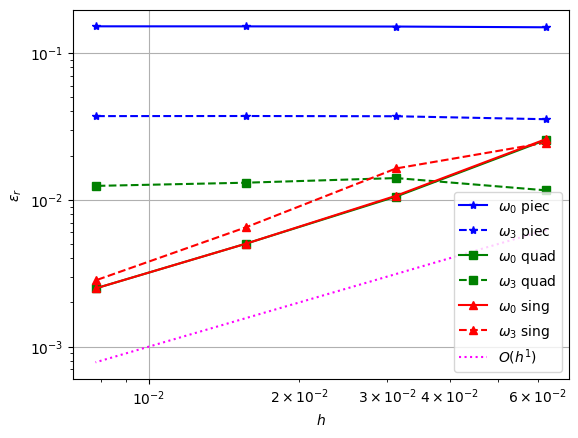

In [79]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_piecewise[0], "*-", label='$\omega_0$ piec', color=colors_list[0])
plt.plot(h_i, rel_error_piecewise[3], "*--", label='$\omega_3$ piec', color=colors_list[0])
plt.plot(h_i, rel_error_quadratic[0], "s-", label='$\omega_0$ quad', color=colors_list[1])
plt.plot(h_i, rel_error_quadratic[3], "s--", label='$\omega_3$ quad', color=colors_list[1])
plt.plot(h_i, rel_error_singular[0], "^-", label='$\omega_0$ sing', color=colors_list[2])
plt.plot(h_i, rel_error_singular[3], "^--", label='$\omega_3$ sing', color=colors_list[2])
plt.plot(
    h_i,
    [1e-1*x**1 for x in h_i],
    linestyle="dotted",
    # marker="o",
    label=f"$O(h^{{{1}}})$",
    color= colors_list[3]
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()